# SIR модель #
Работа выполнена студентом группы 23КНТ2 ИМИКН ВШЭ НН ***Власовым Артёмом Дмитриевичем***

In [346]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [347]:
df = pd.read_excel('Великобритания.xlsx', sheet_name='Sheet1')
df.head()

,Страна,Дата,Заражений,Выздоровлений,Смертей,Заражений за день,Выздоровлений за день,Смертей за день,Население страны,Тестов,Тестов за день
0,Великобритания,20.07.2020,296940,1413.0,41090,586,0.0,10,63181775,8256935,121693
1,Великобритания,21.07.2020,297385,1414.0,41115,445,1.0,25,63181775,8388397,131462
2,Великобритания,22.07.2020,297948,1416.0,41132,563,2.0,17,63181775,8522679,134282
3,Великобритания,23.07.2020,298727,1425.0,41141,779,9.0,9,63181775,8663993,141314
4,Великобритания,24.07.2020,299495,1425.0,41173,768,0.0,32,63181775,8798036,134043


In [348]:
df.tail()

,Страна,Дата,Заражений,Выздоровлений,Смертей,Заражений за день,Выздоровлений за день,Смертей за день,Население страны,Тестов,Тестов за день
604,Великобритания,16.03.2022,20059641,NaN,163833,93943,NaN,153,63181775,476632060,853716
605,Великобритания,17.03.2022,20150847,NaN,163972,91206,NaN,139,63181775,477378853,746793
606,Великобритания,18.03.2022,20243940,NaN,164099,93093,NaN,127,63181775,477950504,571651
607,Великобритания,19.03.2022,20243940,NaN,164099,0,NaN,0,63181775,478578610,628106
608,Великобритания,20.03.2022,20243940,NaN,164099,0,NaN,0,63181775,0,0


Смотрим, в какие столбцах есть пропуски

In [349]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 609 entries, 0 to 608
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Страна                 609 non-null    object 
 1   Дата                   609 non-null    object 
 2   Заражений              609 non-null    int64  
 3   Выздоровлений          381 non-null    float64
 4   Смертей                609 non-null    int64  
 5   Заражений за день      609 non-null    int64  
 6   Выздоровлений за день  381 non-null    float64
 7   Смертей за день        609 non-null    int64  
 8   Население страны       609 non-null    int64  
 9   Тестов                 609 non-null    int64  
 10  Тестов за день         609 non-null    int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 52.5+ KB
None


# Идём по тупому пути и просто складываем к предыдущему значению медиану

In [306]:
median_recovery_per_day = df.loc[:380, 'Выздоровлений за день'].median()

start_index = 381

# Вычисляем значения для столбца 'Выздоровлений' начиная с 381 строки
for i in range(start_index, len(df)):
    df.loc[i, 'Выздоровлений за день'] = df.loc[i-1, 'Выздоровлений за день'] + median_recovery_per_day

df


,Страна,Дата,Заражений,Выздоровлений,Смертей,Заражений за день,Выздоровлений за день,Смертей за день,Население страны,Тестов,Тестов за день
0,Великобритания,20.07.2020,296940,1413.0,41090,586,0.0,10,63181775,8256935,121693
1,Великобритания,21.07.2020,297385,1414.0,41115,445,1.0,25,63181775,8388397,131462
2,Великобритания,22.07.2020,297948,1416.0,41132,563,2.0,17,63181775,8522679,134282
3,Великобритания,23.07.2020,298727,1425.0,41141,779,9.0,9,63181775,8663993,141314
4,Великобритания,24.07.2020,299495,1425.0,41173,768,0.0,32,63181775,8798036,134043
...,...,...,...,...,...,...,...,...,...,...,...
604,Великобритания,16.03.2022,20059641,NaN,163833,93943,4356.0,153,63181775,476632060,853716
605,Великобритания,17.03.2022,20150847,NaN,163972,91206,4374.0,139,63181775,477378853,746793
606,Великобритания,18.03.2022,20243940,NaN,164099,93093,4392.0,127,63181775,477950504,571651
607,Великобритания,19.03.2022,20243940,NaN,164099,0,4410.0,0,63181775,478578610,628106


### Работает с пропущенными значениями 

Как мы видим, начиная с 381 строки в столбцах **'Выздоровлений за день'** и **'Выздоровлений'** вместо данных идут пропуски. Используем линейную регрессию, чтобы обучить на первых 300+ строках, а затем предсказать недостающие значения.

Перейдём к следующим шагам:

1. Построим модель линейной регрессии по непустым данным.

2. Применим её к строкам с пропущенными значениями.

3. Заполним пропуски предсказаниями модели.

In [297]:
from sklearn.linear_model import LinearRegression

# Создаем временной индекс
df["index"] = df.index

# Разделяем на обучающую и предсказуемую выборки
train_data = df[df["Выздоровлений за день"].notnull()]
predict_data = df[df["Выздоровлений за день"].isnull()]

# Признаки и целевая переменная
X_train = train_data[["index"]]
y_train = train_data["Выздоровлений за день"]

# Обучаем модель линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [298]:
# Предсказываем пропущенные значения
X_predict = predict_data[["index"]]
y_predict = model.predict(X_predict)

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by LinearRegression.

In [ ]:
# Получаем индексы строк с NaN
nan_indices = df[df["Выздоровлений за день"].isnull()].index

# Присваиваем только соответствующие значения из y_predict
df.loc[nan_indices, "Выздоровлений за день"] = y_predict.round(0)

# Проверим результат — последние 10 строк
df[["index", "Дата", "Выздоровлений за день"]].tail(10)

df["Выздоровлений за день"] = pd.to_numeric(df["Выздоровлений за день"], downcast='float')

In [331]:
df.tail(20)

,Страна,Дата,Заражений,Выздоровлений,Смертей,Заражений за день,Выздоровлений за день,Смертей за день,Население страны,Тестов,Тестов за день
589,Великобритания,01.03.2022,19120746,NaN,162203,99670,966.0,269,63181775,465963524,719829
590,Великобритания,02.03.2022,19166049,NaN,162278,45303,966.0,75,63181775,466739693,776169
591,Великобритания,03.03.2022,19211944,NaN,162472,45895,966.0,194,63181775,467376382,636689
592,Великобритания,04.03.2022,19256835,NaN,162582,44891,966.0,110,63181775,467854938,478556
593,Великобритания,05.03.2022,19256835,NaN,162582,0,966.0,0,63181775,468407190,552252
594,Великобритания,06.03.2022,19256835,NaN,162582,0,966.0,0,63181775,469158022,750832
595,Великобритания,07.03.2022,19383743,NaN,162722,126908,966.0,140,63181775,469893218,735196
596,Великобритания,08.03.2022,19446892,NaN,162936,63149,966.0,214,63181775,470662848,769630
597,Великобритания,09.03.2022,19515547,NaN,163059,68655,966.0,123,63181775,471435886,773038
598,Великобритания,10.03.2022,19600293,NaN,163203,84746,966.0,144,63181775,472138379,702493


Теперь мы можем избавиться от пропусков в столбце **'Выздоровлений'**, просто просуммировав значения предыдущей ячейки **'Выздоровлений'** и сегодняшней статистики из **'Выздоровлений за день'**. Но для начала узнаем с какой строки начинаются пропуски данных в столбце

In [332]:
df[df["Выздоровлений"].isnull()]

,Страна,Дата,Заражений,Выздоровлений,Смертей,Заражений за день,Выздоровлений за день,Смертей за день,Население страны,Тестов,Тестов за день
381,Великобритания,05.08.2021,6010860,NaN,130388,30030,1077.0,90,63181775,238855296,822864
382,Великобритания,06.08.2021,6042493,NaN,130481,31633,1008.0,93,63181775,239532985,677689
383,Великобритания,07.08.2021,6070872,NaN,130585,28379,982.0,104,63181775,240238517,705532
384,Великобритания,08.08.2021,6098140,NaN,130630,27268,972.0,45,63181775,241006064,767547
385,Великобритания,09.08.2021,6123155,NaN,130667,25015,968.0,37,63181775,241784810,778746
...,...,...,...,...,...,...,...,...,...,...,...
604,Великобритания,16.03.2022,20059641,NaN,163833,93943,966.0,153,63181775,476632060,853716
605,Великобритания,17.03.2022,20150847,NaN,163972,91206,966.0,139,63181775,477378853,746793
606,Великобритания,18.03.2022,20243940,NaN,164099,93093,966.0,127,63181775,477950504,571651
607,Великобритания,19.03.2022,20243940,NaN,164099,0,966.0,0,63181775,478578610,628106


Теперь можно начать считать данные

In [333]:
start_index = 381

# Вычисляем значения для столбца 'Выздоровлений' начиная с 381 строки
for i in range(start_index, len(df)):
    df.loc[i, 'Выздоровлений'] = df.loc[i-1, 'Выздоровлений'] + df.loc[i, 'Выздоровлений за день']

Проверяем работу

In [334]:
df[df["Выздоровлений"].isnull()]

,Страна,Дата,Заражений,Выздоровлений,Смертей,Заражений за день,Выздоровлений за день,Смертей за день,Население страны,Тестов,Тестов за день


In [335]:
df

,Страна,Дата,Заражений,Выздоровлений,Смертей,Заражений за день,Выздоровлений за день,Смертей за день,Население страны,Тестов,Тестов за день
0,Великобритания,20.07.2020,296940,1413.0,41090,586,0.0,10,63181775,8256935,121693
1,Великобритания,21.07.2020,297385,1414.0,41115,445,1.0,25,63181775,8388397,131462
2,Великобритания,22.07.2020,297948,1416.0,41132,563,2.0,17,63181775,8522679,134282
3,Великобритания,23.07.2020,298727,1425.0,41141,779,9.0,9,63181775,8663993,141314
4,Великобритания,24.07.2020,299495,1425.0,41173,768,0.0,32,63181775,8798036,134043
...,...,...,...,...,...,...,...,...,...,...,...
604,Великобритания,16.03.2022,20059641,241255.0,163833,93943,966.0,153,63181775,476632060,853716
605,Великобритания,17.03.2022,20150847,242221.0,163972,91206,966.0,139,63181775,477378853,746793
606,Великобритания,18.03.2022,20243940,243187.0,164099,93093,966.0,127,63181775,477950504,571651
607,Великобритания,19.03.2022,20243940,244153.0,164099,0,966.0,0,63181775,478578610,628106


Удаляем столбец **'Страна'**, **'Тестов'**, **'Тестов за день''**, **'Смертей за день'** и **'index'** поскольку он не несёт никакой полезной информации

In [336]:
df.drop(columns=['Страна'], inplace=True)
df.drop(columns=['Тестов'], inplace=True)
df.drop(columns=['Тестов за день'], inplace=True)
df.drop(columns=['Смертей за день'], inplace=True)
# df.drop(columns=['index'], inplace=True)
df.head()

,Дата,Заражений,Выздоровлений,Смертей,Заражений за день,Выздоровлений за день,Население страны
0,20.07.2020,296940,1413.0,41090,586,0.0,63181775
1,21.07.2020,297385,1414.0,41115,445,1.0,63181775
2,22.07.2020,297948,1416.0,41132,563,2.0,63181775
3,23.07.2020,298727,1425.0,41141,779,9.0,63181775
4,24.07.2020,299495,1425.0,41173,768,0.0,63181775


### 1. Вычислить количество инфицированных I на каждый день наблюдений

In [337]:
df['Инфицированные_I'] = df['Заражений'] - df['Выздоровлений'] - df['Смертей']
df['Восприимчивые_S'] = df['Население страны'] - df['Заражений']
df.head()

,Дата,Заражений,Выздоровлений,Смертей,Заражений за день,Выздоровлений за день,Население страны,Инфицированные_I,Восприимчивые_S
0,20.07.2020,296940,1413.0,41090,586,0.0,63181775,254437.0,62884835
1,21.07.2020,297385,1414.0,41115,445,1.0,63181775,254856.0,62884390
2,22.07.2020,297948,1416.0,41132,563,2.0,63181775,255400.0,62883827
3,23.07.2020,298727,1425.0,41141,779,9.0,63181775,256161.0,62883048
4,24.07.2020,299495,1425.0,41173,768,0.0,63181775,256897.0,62882280


### 2. Выполнить нормировку данных на 100 тыс. населения

In [338]:
pop = df['Население страны'].iloc[0]
df['Инфицированные на 100 тыс.'] = df['Инфицированные_I'] * 100000 / pop
df['Заражений на 100 тыс.'] = df['Заражений'] * 100000 / pop

In [339]:
df.head()

,Дата,Заражений,Выздоровлений,Смертей,Заражений за день,Выздоровлений за день,Население страны,Инфицированные_I,Восприимчивые_S,Инфицированные на 100 тыс.,Заражений на 100 тыс.
0,20.07.2020,296940,1413.0,41090,586,0.0,63181775,254437.0,62884835,402.706318,469.977300
1,21.07.2020,297385,1414.0,41115,445,1.0,63181775,254856.0,62884390,403.369484,470.681617
2,22.07.2020,297948,1416.0,41132,563,2.0,63181775,255400.0,62883827,404.230492,471.572696
3,23.07.2020,298727,1425.0,41141,779,9.0,63181775,256161.0,62883048,405.434953,472.805647
4,24.07.2020,299495,1425.0,41173,768,0.0,63181775,256897.0,62882280,406.599846,474.021187


### 3.На основе данных построить оценку параметра γ – интенсивности выздоровления

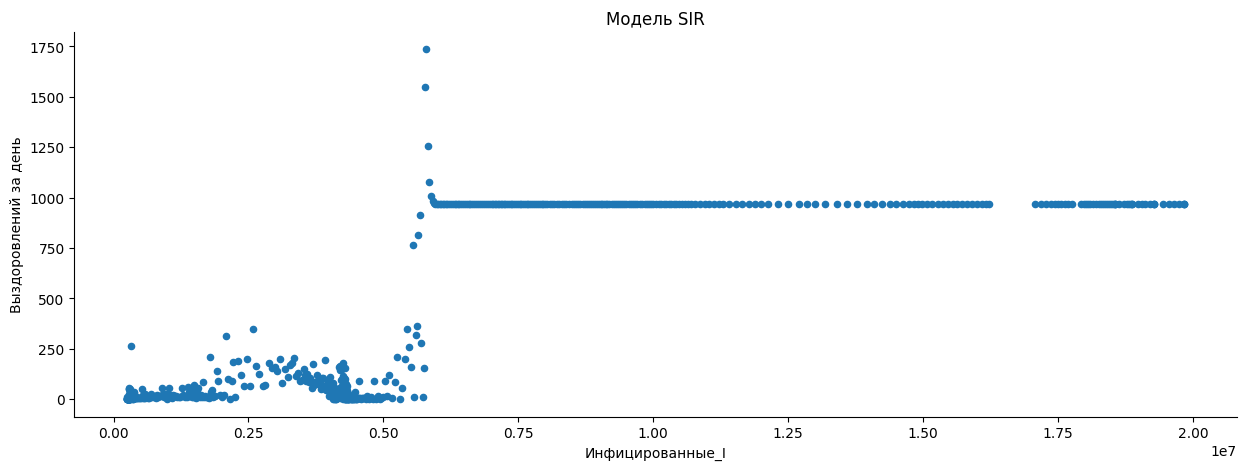

In [340]:
df.plot(kind='scatter', x='Инфицированные_I', y='Выздоровлений за день',figsize=(15, 5), title='Модель SIR')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [341]:
gamma = sum(df['Выздоровлений за день'] *df['Инфицированные_I'] / sum(df['Инфицированные_I'] * df['Инфицированные_I']))
print('параметр гамма', gamma)
print('средняя продолжительность заболевания', 1/gamma)

параметр гамма 6.774143779479801e-05
средняя продолжительность заболевания 14762.013216034688


In [342]:
import statsmodels.formula.api as smf

df.rename(columns={'Выздоровлений за день': 'Выздоровлений_за_день'}, inplace=True)
lm = smf.ols(formula='Выздоровлений_за_день ~ Инфицированные_I', data=df).fit()
lm.params
print(lm.summary())

                              OLS Regression Results                             
Dep. Variable:     Выздоровлений_за_день   R-squared:                       0.632
Model:                               OLS   Adj. R-squared:                  0.631
Method:                    Least Squares   F-statistic:                     1041.
Date:                   Sun, 13 Apr 2025   Prob (F-statistic):          8.70e-134
Time:                           14:30:52   Log-Likelihood:                -4287.5
No. Observations:                    609   AIC:                             8579.
Df Residuals:                        607   BIC:                             8588.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept 

### 4. С помощью метода наименьших квадратов построить оценку параметра SIR-модели β (интенсивность заражения) в предположении, что изначально все население является восприимчивым к заболеванию.

In [ ]:
def sir_model(t, beta):
    S = pop - df['Заражений'].iloc[0]  # Начальное количество восприимчивых
    I = df['Заражений'].iloc[0]  # Начальное количество инфицированных
    R = 0  # Начальное число выздоровевших

    dt = 1  # Временной шаг
    I_vals = []

    for _ in range(len(df)):
        new_infected = beta * S * I / pop
        new_recovered = gamma * I

        S -= new_infected * dt
        I += (new_infected - new_recovered) * dt
        R += new_recovered * dt

        I_vals.append(I)

    return np.array(I_vals)

In [ ]:
df

,Дата,Заражений,Выздоровлений,Смертей,Заражений за день,Выздоровлений_за_день,Население страны,Инфицированные_I,Восприимчивые_S,Инфицированные на 100 тыс.,Заражений на 100 тыс.
0,20.07.2020,296940,1413.0,41090,586,0.0,63181775,254437.0,62884835,402.706318,469.977300
1,21.07.2020,297385,1414.0,41115,445,1.0,63181775,254856.0,62884390,403.369484,470.681617
2,22.07.2020,297948,1416.0,41132,563,2.0,63181775,255400.0,62883827,404.230492,471.572696
3,23.07.2020,298727,1425.0,41141,779,9.0,63181775,256161.0,62883048,405.434953,472.805647
4,24.07.2020,299495,1425.0,41173,768,0.0,63181775,256897.0,62882280,406.599846,474.021187
...,...,...,...,...,...,...,...,...,...,...,...
604,16.03.2022,20059641,550869.0,163833,93943,4356.0,63181775,19344939.0,43122134,30617.909991,31749.093785
605,17.03.2022,20150847,555243.0,163972,91206,4374.0,63181775,19431632.0,43030928,30755.122027,31893.448704
606,18.03.2022,20243940,559635.0,164099,93093,4392.0,63181775,19520206.0,42937835,30895.311187,32040.790244
607,19.03.2022,20243940,564045.0,164099,0,4410.0,63181775,19515796.0,42937835,30888.331327,32040.790244


In [ ]:
from scipy.optimize import curve_fit

t_values = np.arange(len(df))
beta_opt, _ = curve_fit(sir_model, t_values, df['Инфицированные_I'])

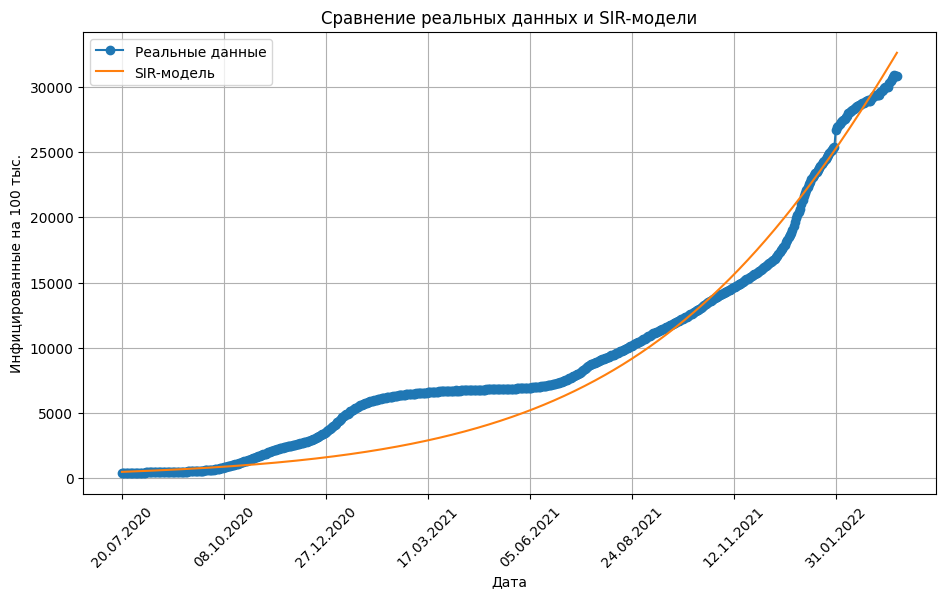

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure(figsize=(11, 6))
plt.plot(df['Дата'], df['Инфицированные на 100 тыс.'], label='Реальные данные', marker='o')
plt.plot(df['Дата'], sir_model(t_values, beta_opt[0]) * 100000 / pop, label='SIR-модель', linestyle='-')

plt.xlabel('Дата')
plt.ylabel('Инфицированные на 100 тыс.')
plt.title('Сравнение реальных данных и SIR-модели')
plt.legend()

plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))

plt.grid()
plt.show()
